<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Capstone Project: Rossmann Drugstore

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

This machine learning project is taken from Kaggle. The link to the Kaggle competition page is https://www.kaggle.com/c/rossmann-store-sales

In their first Kaggle competition, Rossmann is challenging you to predict **7 weeks of daily sales for 1,115 stores** located across Germany. Reliable sales forecasts enable store managers to create effective staff schedules that increase productivity and motivation. By helping Rossmann create a robust prediction model, you will help store managers stay focused on what’s most important to them: their customers and their teams! 

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Fn 1: Root Mean Squared Percentage Error Function

According to Kaggle, submissions are evaluated on the Root Mean Square Percentage Error (RMSPE). The RMSPE is calculated as such:

$$RMSPE = \sqrt{\frac{1}{n}\sum_{i=1}^n\left(\frac{y_i - \hat{y}_i}{y_i}\right)^{2}}$$

The code below is a function that calculates the RMSPE.

In [2]:
# Function that calculates and returns the RMSPE
def rmspe(y_test, y_pred):
    
    y_test=np.array(y_test)
    y_pred=np.array(y_pred)

    ytest_ypred = pd.DataFrame(y_test, y_pred).reset_index()
    ytest_ypred.columns = ['Predicted_Sales','Actual_Sales']

    # Removing rows that contain zero to prevent division by zero when calculating RMSPE
    ytest_ypred.drop(ytest_ypred[ytest_ypred['Actual_Sales']==0].index,axis=0, inplace=True)

    rmspe = np.sqrt(np.mean(((ytest_ypred['Actual_Sales']-ytest_ypred['Predicted_Sales']) / ytest_ypred['Actual_Sales']) ** 2))
    return rmspe

# Fn 2: Residuals Plotting Function

The code below is a function that plots the residuals against time. Residuals are defined as the difference between the actual sales values and the predicted sales values.

Residual plots are a way to visualize how the errors are distributed. Ideally, the errors should be distributed randomly with a mean of zero, and the standard deviation of the errors should not change with time.

In [3]:
# Function that plots residuals against time for train_validation dataset
def residual_plot(y_pred, train_sub_val_file_path, model_type):
    
    train_sub_validation = pd.read_csv(train_sub_val_file_path, index_col = 0, dtype=types)
    train_sub_validation['Date'] = pd.to_datetime(train_sub_validation['Date'])
    
    plotting_df = pd.DataFrame()
    plotting_df[['Date','Sales']] = train_sub_validation[['Date', 'Sales']]
    plotting_df['Predicted_Sales'] = np.array(y_pred)

    plotting_df['Residuals'] = plotting_df['Sales'] - plotting_df['Predicted_Sales']
    
    # Calculating the mean
    residual_mean = plotting_df['Residuals'].mean()
    
    # Calculating the standard deviations
    residual_std = plotting_df['Residuals'].std()
    
    # Plotting the residuals
    fig, ax = plt.subplots(figsize = (16,8))
    ax.scatter(plotting_df['Date'].values, plotting_df['Residuals'].values, marker='+', alpha = 0.5)
    ax.set_xlabel('Time')
    ax.set_ylabel('Sales residuals')
    ax.set_title('Scatterplot of {} residuals against time'.format(model_type))
    
    # Plotting the mean of residuals as a horizontal line
    ax.axhline(y=residual_mean, color='black')
    ax.text('2015-06-08', residual_mean, 'mean={:.1f}'.format(residual_mean), fontsize=10, backgroundcolor='w')
    
    # Plotting the first standard deviations as horizontal lines
    ax.axhline(y=residual_mean+residual_std, color='black', linestyle = ':')
    ax.axhline(y=residual_mean-residual_std, color='black', linestyle = ':')
    ax.text('2015-08-05', residual_mean+residual_std, '+1 standard deviation', fontsize=10, backgroundcolor='w')
    ax.text('2015-08-05', residual_mean-residual_std, '-1 standard deviation', fontsize=10, backgroundcolor='w')
    
    return ax

# Fn 3: Residual mean and standard deviation function

The code below is a function that calculates and returns the mean and standard deviations of the residuals

In [4]:
def residual_mean_std(y_pred, train_sub_val_file_path):
    
    train_sub_validation = pd.read_csv(train_sub_val_file_path, index_col = 0, dtype=types)
    train_sub_validation['Date'] = pd.to_datetime(train_sub_validation['Date'])
    
    df = pd.DataFrame()
    df[['Date','Sales']] = train_sub_validation[['Date', 'Sales']]
    df['Predicted_Sales'] = np.array(y_pred)
    df['Residuals'] = df['Sales'] - df['Predicted_Sales']
    
    # Calculating the mean
    residual_mean = df['Residuals'].mean()
    
    # Calculating the standard deviations
    residual_std = df['Residuals'].std()
    
    return(residual_mean, residual_std)

# Fn 4: Actual sales vs Predicted sales plot function

The code below is a function that plots out the time series plots of actual sales and predicted sales of selected stores in the train_validation dataset.

In [5]:
# Plotting the actual sales and predicted sales of the train_validation dataframe for selected stores
def actual_pred_sales_plot(y_pred, train_sub_val_file_path):

    # Import train_validation.csv into a dataframe
    train_sub_validation = pd.read_csv(train_sub_val_file_path, index_col = 0, dtype=types)
    train_sub_validation['Date'] = pd.to_datetime(train_sub_validation['Date'])
    
    # Incorporate y_pred into train_validation dataframe
    train_sub_validation['Predicted_Sales'] = y_pred
    
    selected_stores = [2, 7, 85, 259, 562, 1, 4, 732, 530, 512]

    for store_id in selected_stores:
        fig, ax = plt.subplots(figsize = (16,3))
        ax.plot(train_sub_validation[train_sub_validation['Store']==store_id]['Date'], train_sub_validation[train_sub_validation['Store']==store_id]['Sales'])
        ax.plot(train_sub_validation[train_sub_validation['Store']==store_id]['Date'], train_sub_validation[train_sub_validation['Store']==store_id]['Predicted_Sales'])
        ax.set_title('Plot of actual sales and predicted sales against time for Store {}'.format(store_id))
        ax.set_ylabel('Sales')
        plt.legend()
        plt.show()

    return ax

# Basic EDA to create baseline model

We will first conduct a rudimentary exploratory data analysis so that we can quickly establish baseline models to predict the next 6 weeks of sales.

In [6]:
# Import the train_sub dataset
types = {'StateHoliday': np.dtype(str)}

train_sub = pd.read_csv('train_sub.csv', dtype=types, parse_dates=[3]).iloc[:,1:]
train_sub.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-06-19,4202,487,1,1,0,0
1,2,5,2015-06-19,4926,544,1,1,0,0
2,3,5,2015-06-19,8074,797,1,1,0,0
3,4,5,2015-06-19,9686,1281,1,1,0,0
4,5,5,2015-06-19,5711,610,1,1,0,0


In [7]:
# Checking which days have the greatest number of zero sales
train_sub[train_sub['Sales'] == 0]['DayOfWeek'].value_counts()

7    134640
4     11209
5      7203
1      7165
3      3735
2      1701
6       670
Name: DayOfWeek, dtype: int64

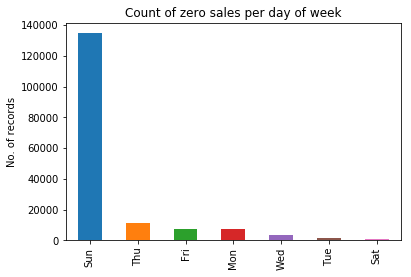

In [8]:
# Plotting the above result as bar plot
index={1:'Mon', 2:'Tue', 3:'Wed', 4:'Thu', 5:'Fri', 6:'Sat', 7:'Sun'}
train_sub[(train_sub['Open']==0) & (train_sub['Sales'] == 0)]['DayOfWeek'].value_counts().rename(index=index).plot(kind='bar')
plt.ylabel('No. of records')
plt.title('Count of zero sales per day of week')
plt.show()

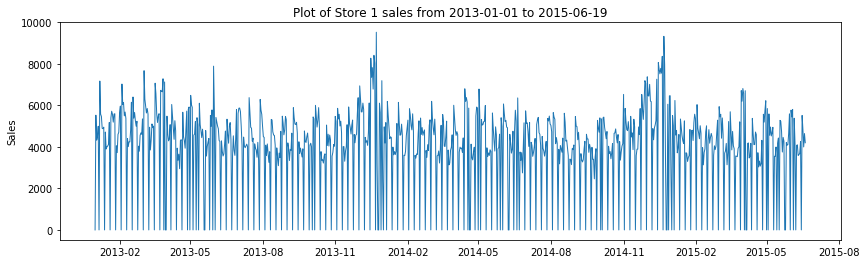

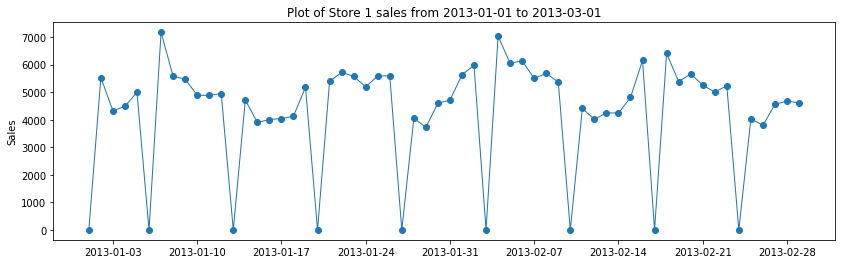

In [9]:
# train_store1 is a subset of train_sub, featuring records only from store 1
train_store1 = train_sub[train_sub['Store']==1]

# Plotting sales of Store 1 against time
plt.figure(figsize = (14,4))
plt.plot(train_store1['Date'], train_store1['Sales'], lw=1)
plt.title('Plot of Store 1 sales from 2013-01-01 to 2015-06-19')
plt.ylabel('Sales')

# Plot the sales time series from 2013-01-01 to 2013-03-01
plt.figure(figsize = (14,4))
plt.plot(train_store1[-60:]['Date'], train_store1[-60:]['Sales'], lw=1, marker='o')
plt.title('Plot of Store 1 sales from 2013-01-01 to 2013-03-01')
plt.ylabel('Sales')
plt.show()

Thus, we can confirm that most stores in the train DataFrame do not open on Sundays, and hence do not clock any sales on Sundays. However, there are some stores that do operate on Sundays in the DataFrame, although it may not be every Sunday. The code below plots out the time series of such stores.

In [10]:
# Identify stores that operate on Sundays, and save them to sun_list
sun_list = list(train_sub[(train_sub['DayOfWeek'] == 7) & (train_sub['Open'] == 1)]['Store'].unique())
print(sun_list,'\n')
print('There are {} stores that open on at least one Sunday'.format(len(sun_list)),'\n')

[85, 122, 209, 259, 262, 274, 299, 310, 335, 353, 423, 433, 453, 494, 512, 524, 530, 562, 578, 676, 682, 732, 733, 769, 863, 867, 931, 948, 1045, 1081, 1097, 1099, 877] 

There are 33 stores that open on at least one Sunday 



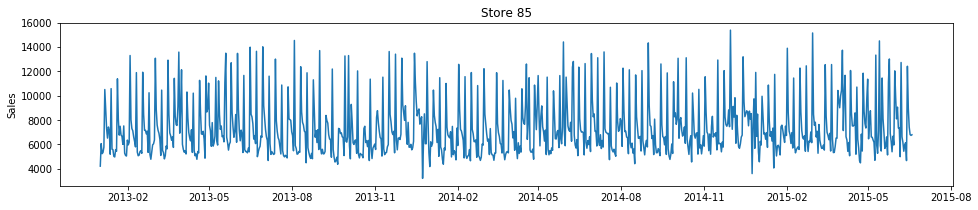

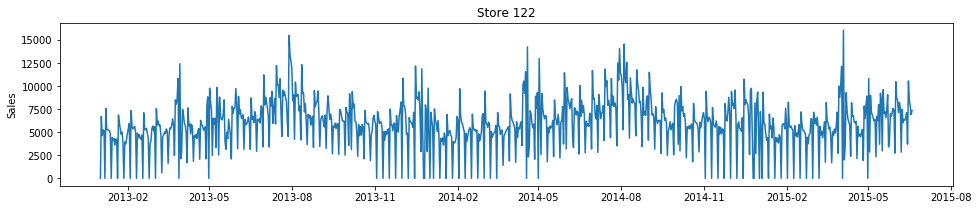

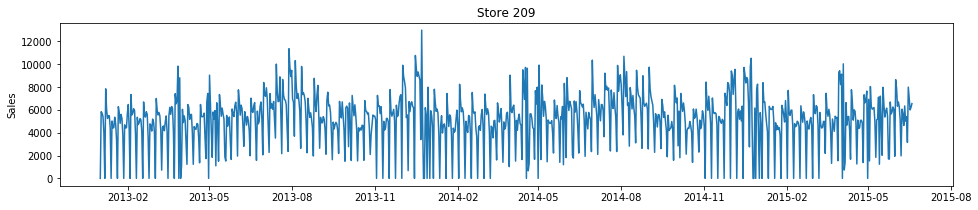

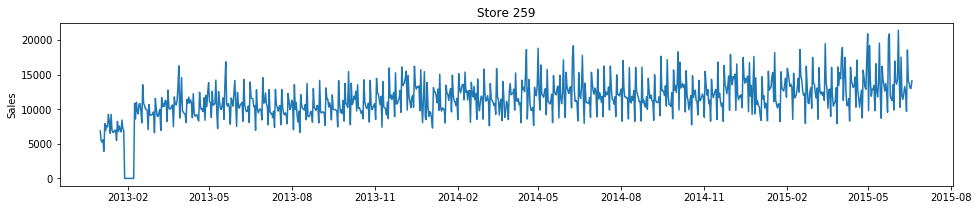

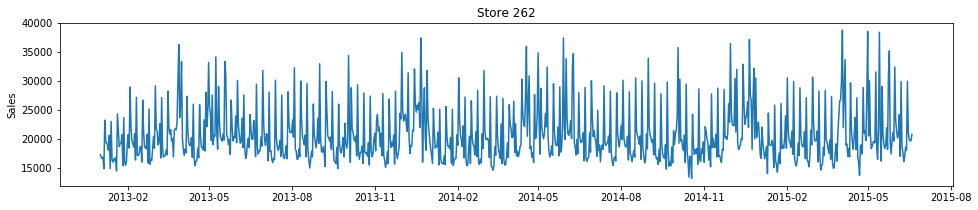

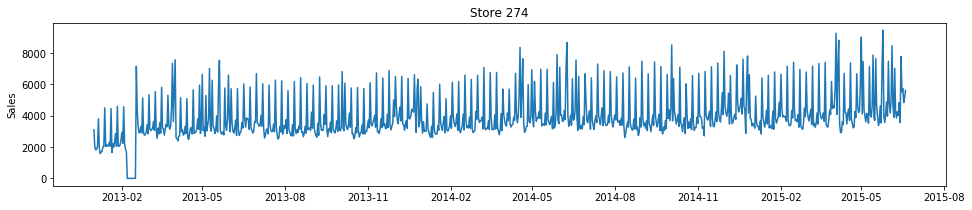

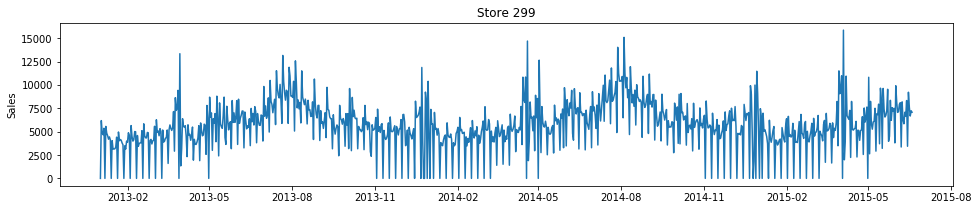

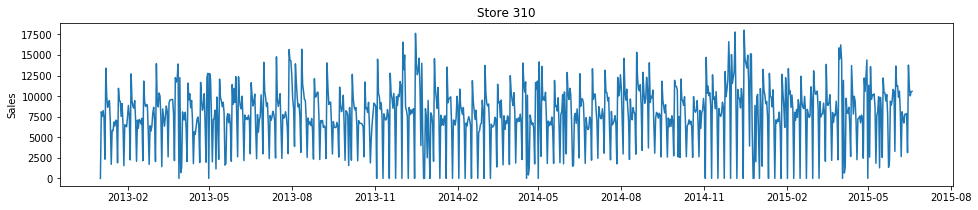

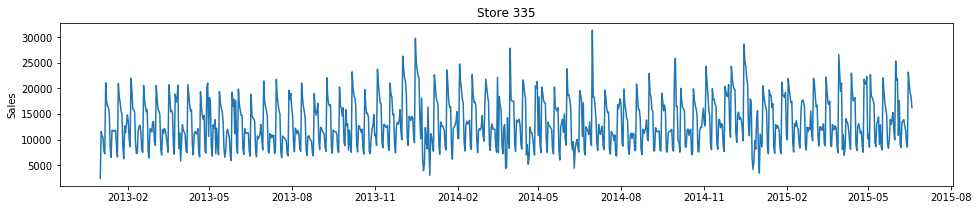

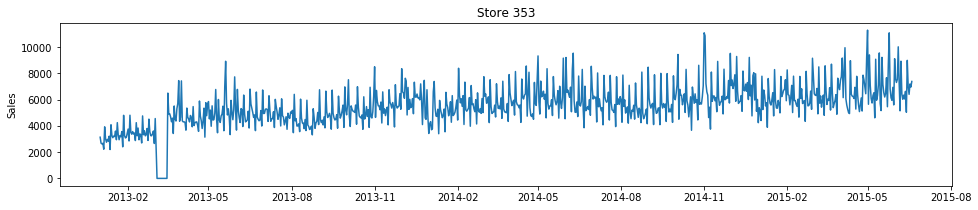

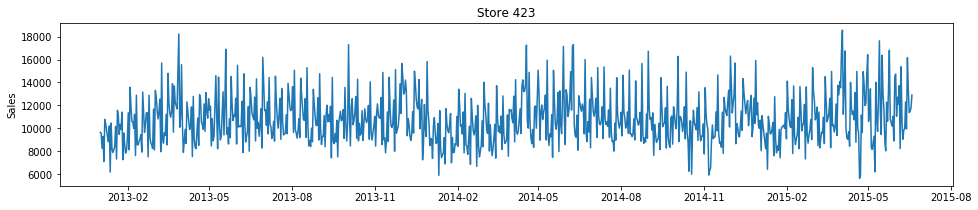

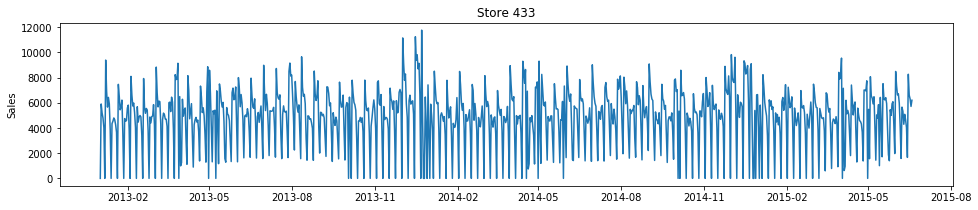

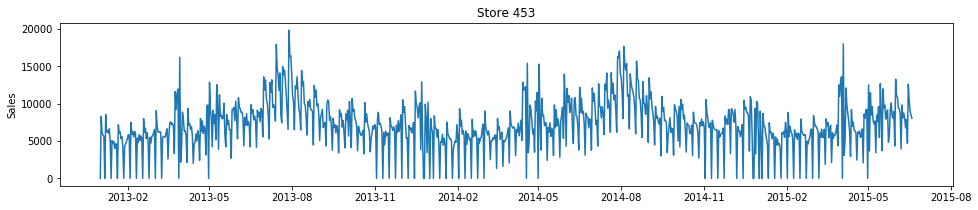

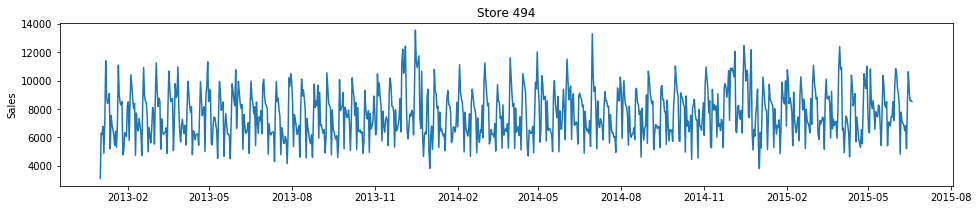

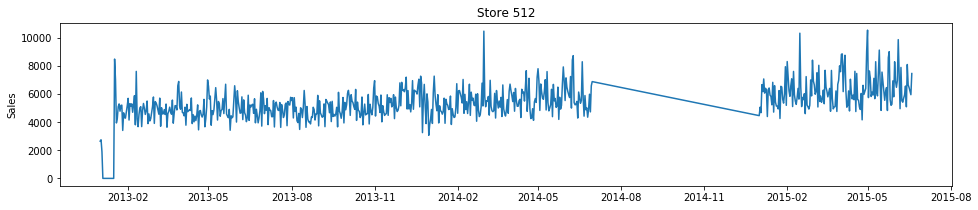

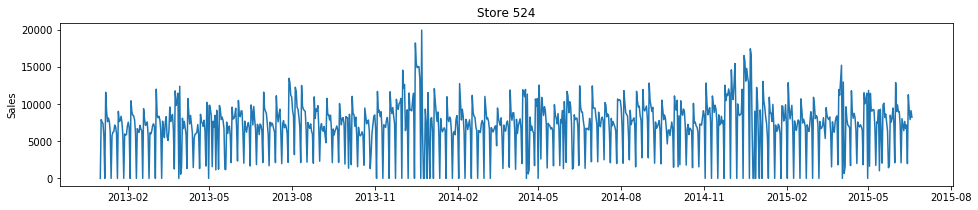

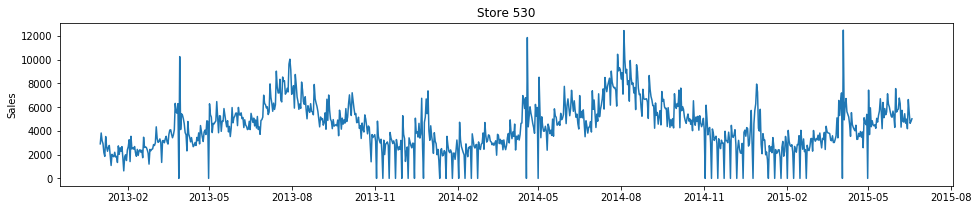

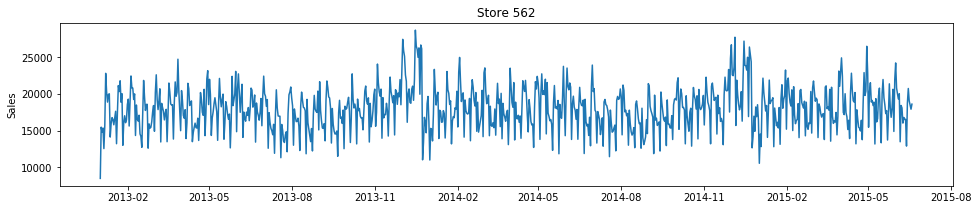

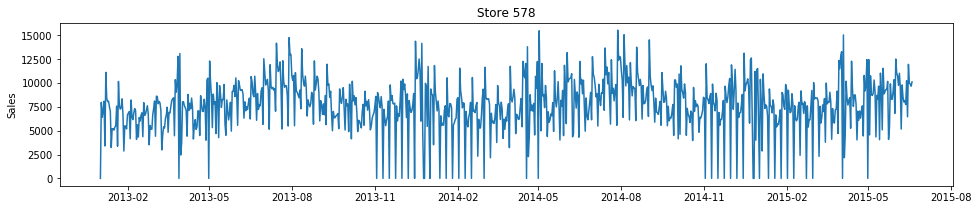

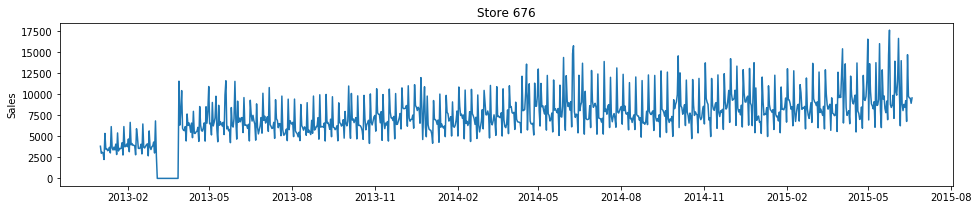

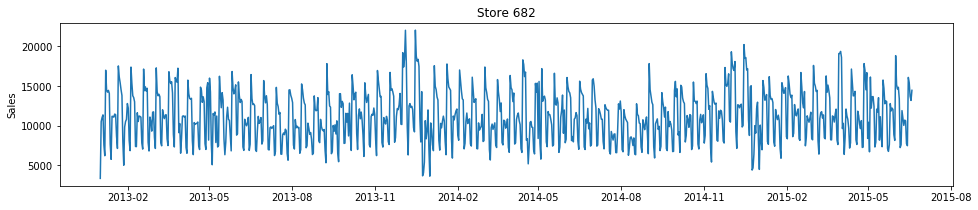

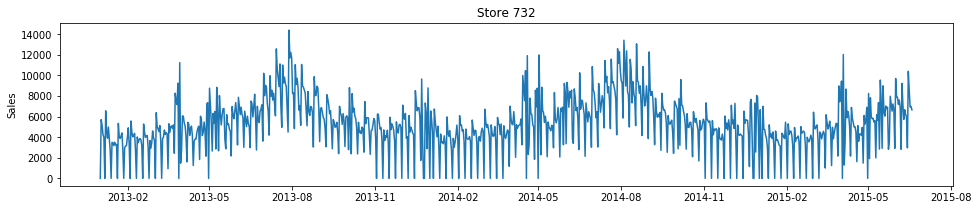

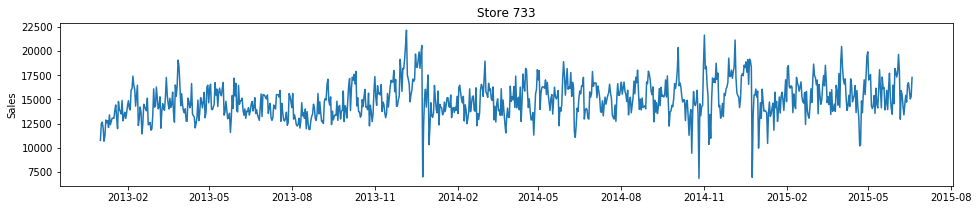

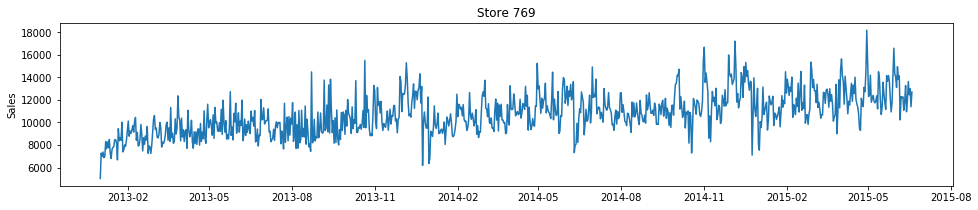

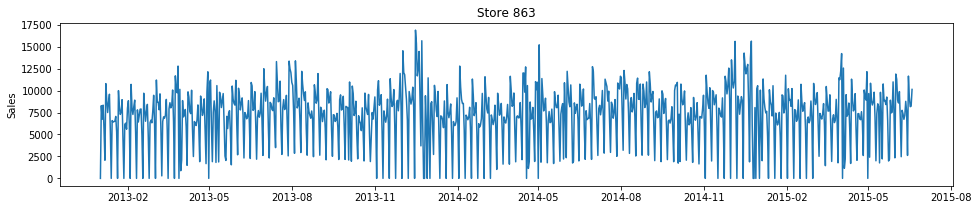

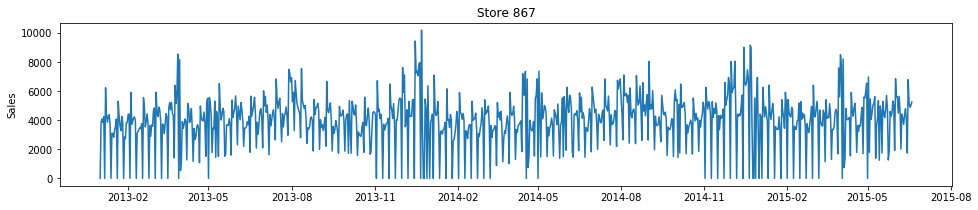

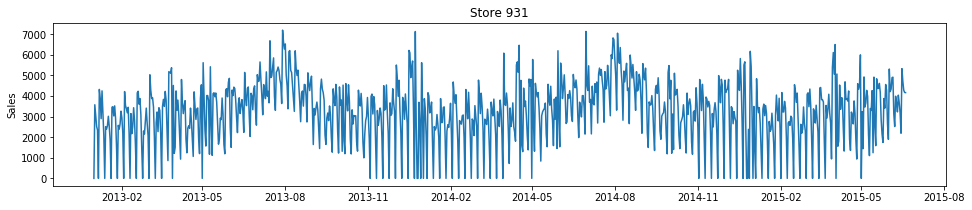

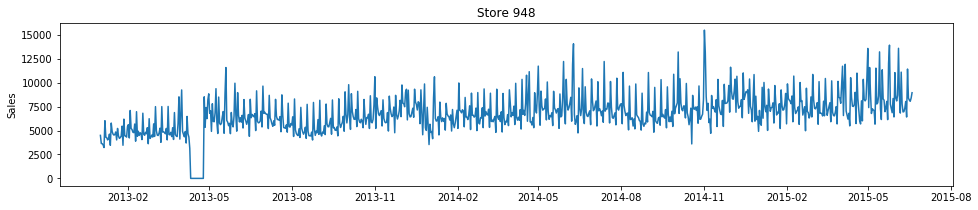

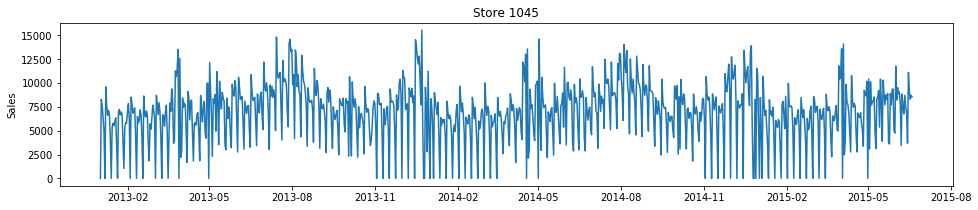

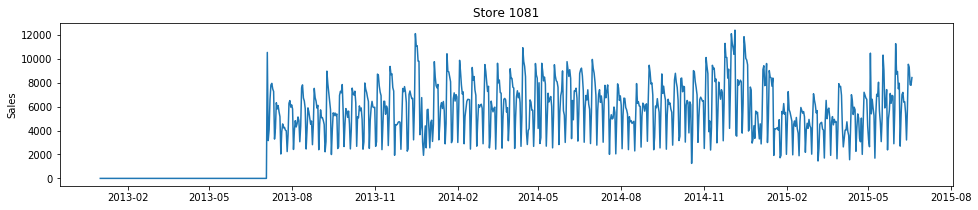

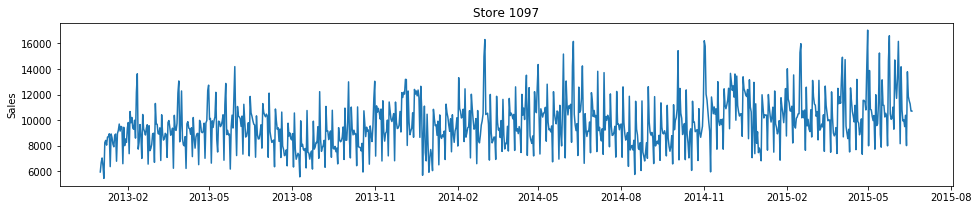

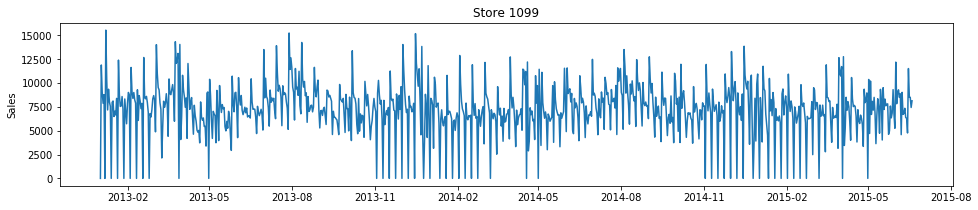

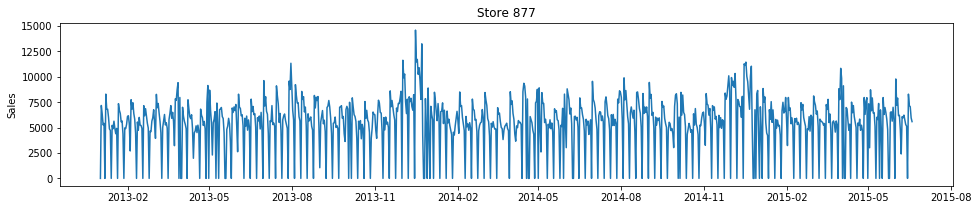

In [11]:
# Plot out the sales time series of stores that operate on Sundays.
for store_id in sun_list:
    plt.figure(figsize = (16,3))
    plt.plot(train_sub[train_sub['Store']==store_id]['Date'], train_sub[train_sub['Store']==store_id]['Sales'])
    plt.title('Store {}'.format(store_id))
    plt.ylabel('Sales')
    plt.show()

We observe that most of the stores in sun_list are open on Sundays in mid-2015. Hence for the sake of our baseline model, we shall assume that these stores will continue to operate on all Sundays.

# Baseline Model #1 - Predict using mean sales in past 2.5 years

Baseline Model #1 uses the mean sales of each store over the last 2.5 years to predict the daily sales for the next six weeks for each store, except on Sundays, where the sales is zero. However, the stores which we have identified in sun_list will not have their sales converted to zero on Sundays, since we assume that these stores will continue to operate on Sundays.

In [12]:
# Import the train_sub_validation dataset
types = {'StateHoliday': np.dtype(str)}

train_sub_validation = pd.read_csv('train_sub_validation.csv', dtype=types, parse_dates=[3]).iloc[:,1:]
train_sub_validation.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [13]:
# Creating our baseline model#1

# Generating the mean sales for each store. These values will serve as the baselines for each store.
mean_sales_df = train_sub.groupby('Store')['Sales'].mean()
mean_sales_df = mean_sales_df.reset_index()

# Append the mean_sales to the validation dataset
merged_df = pd.merge(train_sub_validation, mean_sales_df, how='left', on='Store')
merged_df.rename(columns={'Sales_x':'Actual_Sales', 'Sales_y': 'Predicted_Sales'}, inplace=True)

# Set sales = 0 on Sundays (DayOfWeek == 7), except those stores in the sun_storelist
merged_df.loc[((merged_df['DayOfWeek'] == 7) & (~merged_df['Store'].isin(sun_list))),'Predicted_Sales'] = 0

# Calculate the RMSPE for our baseline model
print('The RMSPE of the baseline model is {:.5f}'.format(rmspe(merged_df['Actual_Sales'], merged_df['Predicted_Sales'])))

The RMSPE of the baseline model is 0.29161


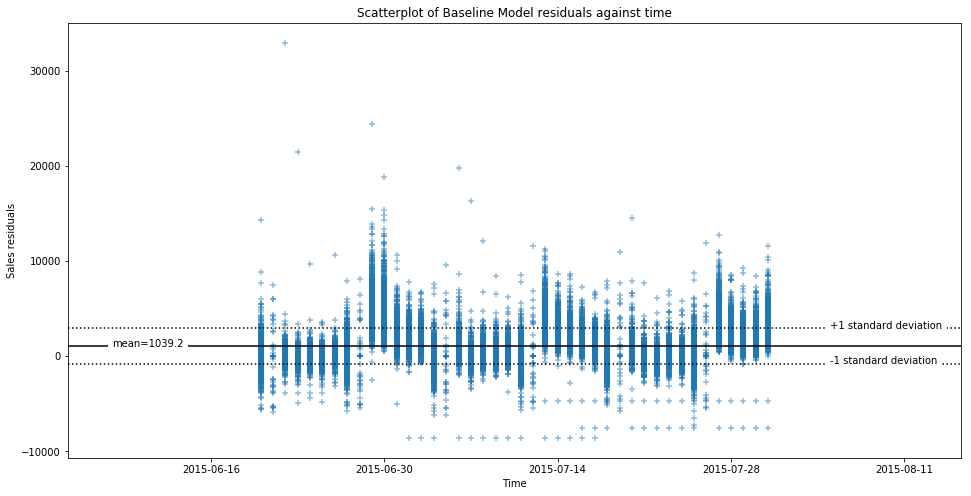

In [14]:
# Plotting out the residuals of the baseline model#1
residual_plot(merged_df['Predicted_Sales'], 'train_sub_validation.csv','Baseline Model')
plt.show()

In [15]:
# Mean of baseline model #1 residuals
print('The mean of the residuals of baseline model #1 is {:.3f}'.format(residual_mean_std(merged_df['Predicted_Sales'],'train_sub_validation.csv')[0]))

# Standard deviation of baseline model #1 residuals
print('The standard deviation of the residuals of baseline model #1 is {:.3f}'.format(residual_mean_std(merged_df['Predicted_Sales'],'train_sub_validation.csv')[1]))

The mean of the residuals of baseline model #1 is 1039.151
The standard deviation of the residuals of baseline model #1 is 1886.832


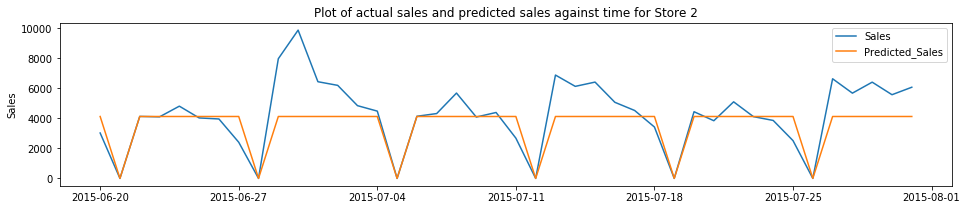

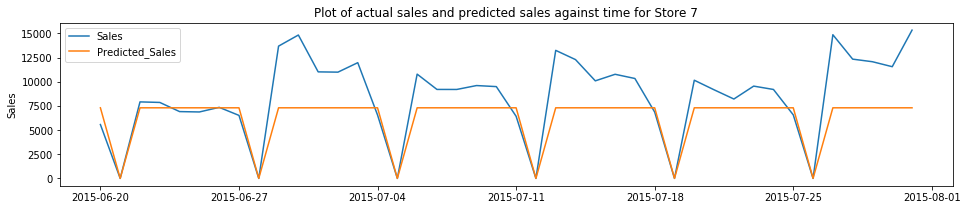

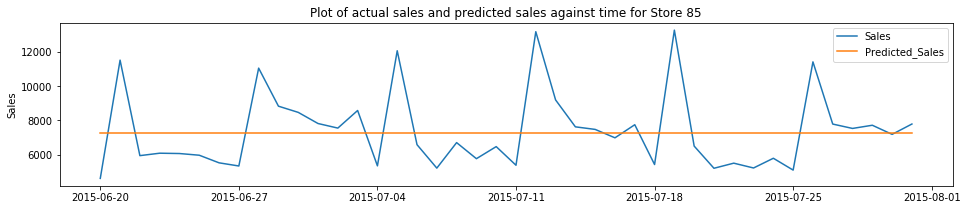

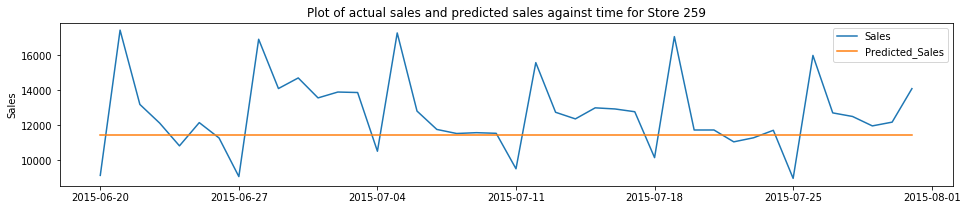

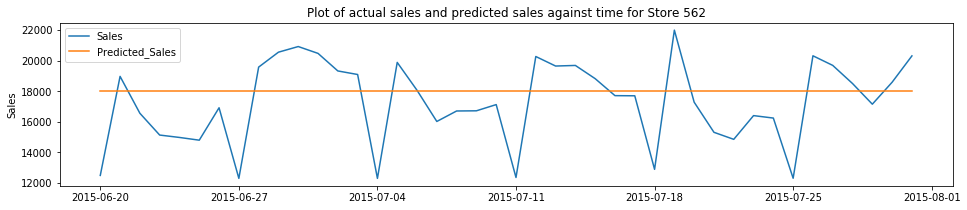

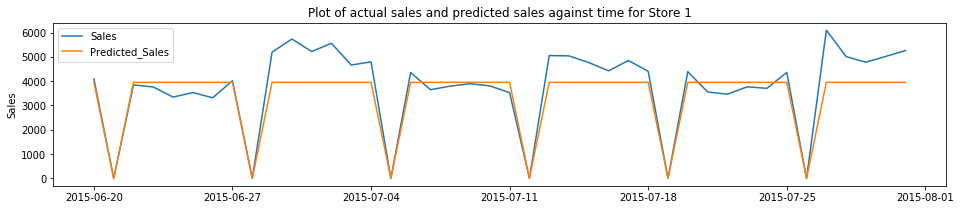

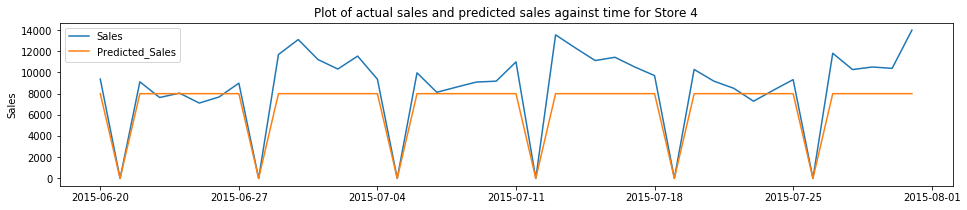

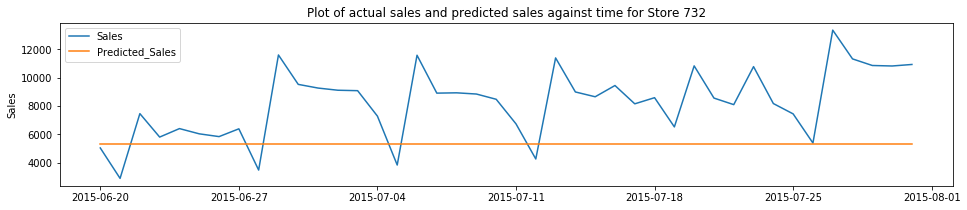

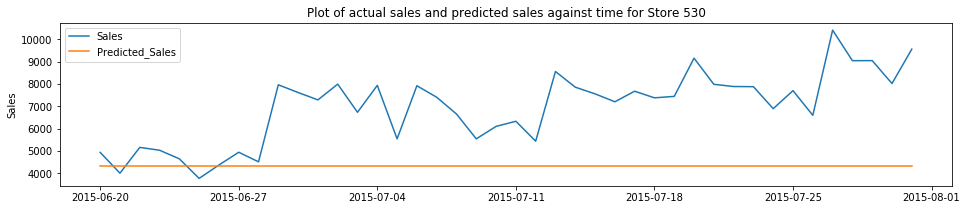

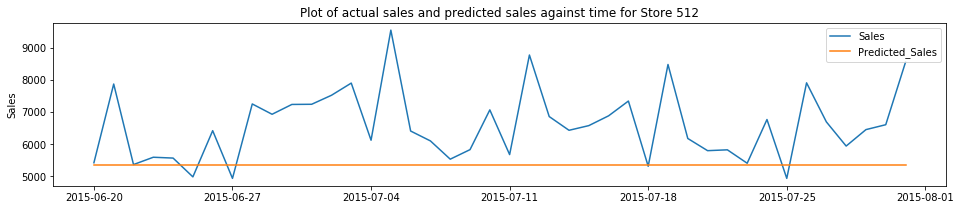

In [16]:
# Plotting the actual sales and predicted sales of the train_validation dataframe for selected stores

actual_pred_sales_plot(merged_df['Predicted_Sales'], 'train_sub_validation.csv')
plt.show()

The points below states the RMSPE and the shortcomings of the baseline model.

- The RMSPE of the basline model is **29.161%**.
- The residuals have a positive mean, which means that the baseline model's predictions tend to underestimate future sales.
- The standard deviation of the predictions is quite large. 
- The residuals do not appear to be distributed randomly about the mean - the residuals tend to be largest on Mondays, and smallest on Saturdays. There is a pattern to the residuals.

# Evaluation of Baseline Model #1 on test set

We will be generating sales predictions for the test set, and upload the results to Kaggle to see what score will be achieved.

In [18]:
# Import the test dataset
types = {'StateHoliday': np.dtype(str)}

test = pd.read_csv('test.csv', dtype=types, parse_dates=[3])
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [19]:
mean_sales_df.head()

,Store,Sales
0,1,3954.151111
1,2,4117.608889
2,3,5735.716667
3,4,7996.461111
4,5,3868.471111


In [20]:
# Append the mean_sales to the validation dataset
test_merged_df = pd.merge(test, mean_sales_df, how='left', on='Store')

# Set sales = 0 on Sundays (DayOfWeek == 7), except those stores in the sun_storelist
test_merged_df.loc[((test_merged_df['DayOfWeek'] == 7) & (~test_merged_df['Store'].isin(sun_list))),'Sales'] = 0

test_merged_df.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Sales
0,1,1,4,2015-09-17,1.0,1,0,0,3954.151111
1,2,3,4,2015-09-17,1.0,1,0,0,5735.716667
2,3,7,4,2015-09-17,1.0,1,0,0,7305.230000
3,4,8,4,2015-09-17,1.0,1,0,0,4571.188889
4,5,9,4,2015-09-17,1.0,1,0,0,5387.097778


In [22]:
test_submission= test_merged_df[['Id','Sales']]
test_submission.index = test_submission['Id']
test_submission.drop('Id', axis=1, inplace=True)
test_submission.to_csv('Baseline_Model_1.csv')

C:\Users\dsiow\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


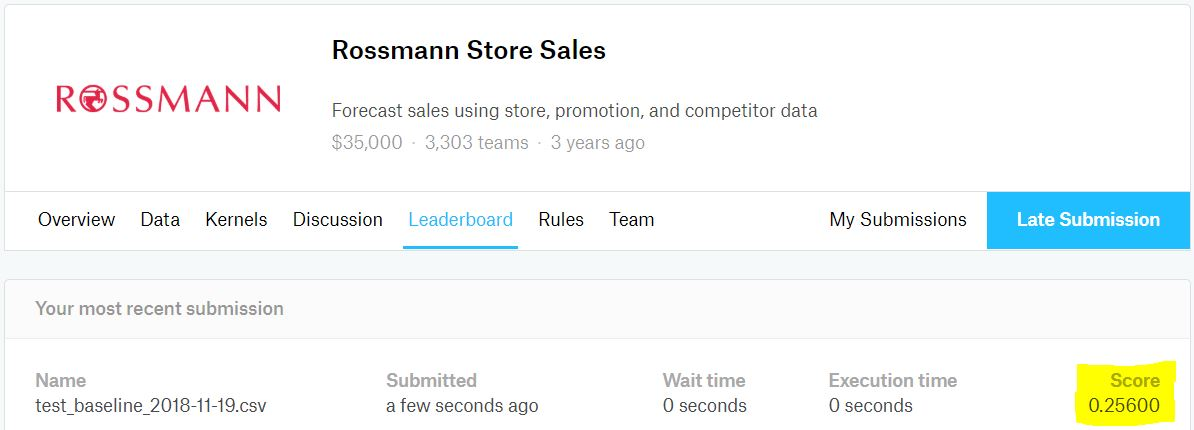

The rmspe score by Kaggle on the baseline model is 0.25600, which is slightly better than the rmspe score of 0.29161 on our train_validation set.